In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.site_models import SeeingModel

With v2.2 we started putting a requirement that gri bands got at least 3 good seeing images per year (good = better than 0.8" delivered IQ). 

In [2]:
families = maf.archive.get_family_descriptions('runs_v2.2.json')
family_list = families.index.values
summary_source = 'summaries_2022_11_08.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_sets = maf.get_metric_sets(metrics_source)

# list the metric sets
msets = list(metric_sets.groupby('metric set').first().index)

In [3]:
ddir = os.getenv("OPSIM_DB_DIR")
if ddir is None:
    ddir = '/Users/lynnej/opsim'

draft_runs = list(families.explode('run').loc['draft v3', 'run'])

opsdb = {}
t = families.explode(['run', 'filepath']).loc['draft v3', ['run', 'filepath']].set_index('run')
for r in draft_runs:
    fpath = os.path.join(ddir, t.loc[r, 'filepath'])
    if os.path.isfile(fpath):
        opsdb[r] = fpath
    else:
        print(f'No file at {fpath}')
t = families.explode(['run', 'filepath']).loc['baseline', ['run', 'filepath']].set_index('run')
for r in ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.2_10yrs']:
    fpath = os.path.join(ddir, t.loc[r, 'filepath'])    
    if os.path.isfile(fpath):
        opsdb[r] = fpath
    else:
        print(f'No file at {fpath}')

No file at /Users/lynnej/opsim/fbs_2.0/retro/retro_baseline_v2.0_10yrs.db
No file at /Users/lynnej/opsim/fbs_2.0/baseline/baseline_v2.0_10yrs.db


In [4]:
# Let's just grab the raw seeing and delivered IQ for each of these directly 
import sqlite3

d = {}
for r in opsdb:
    conn = sqlite3.connect(opsdb[r])
    query = 'select observationStartMJD, night, filter, airmass, seeingFwhm500, seeingFwhmEff, '
    query += 'skyBrightness, fiveSigmaDepth, moonPhase from observations where note not like "%DD%" '
    query += ' and note not like "%twi%"'
    d[r] = pd.read_sql(query, conn)
    conn.close()

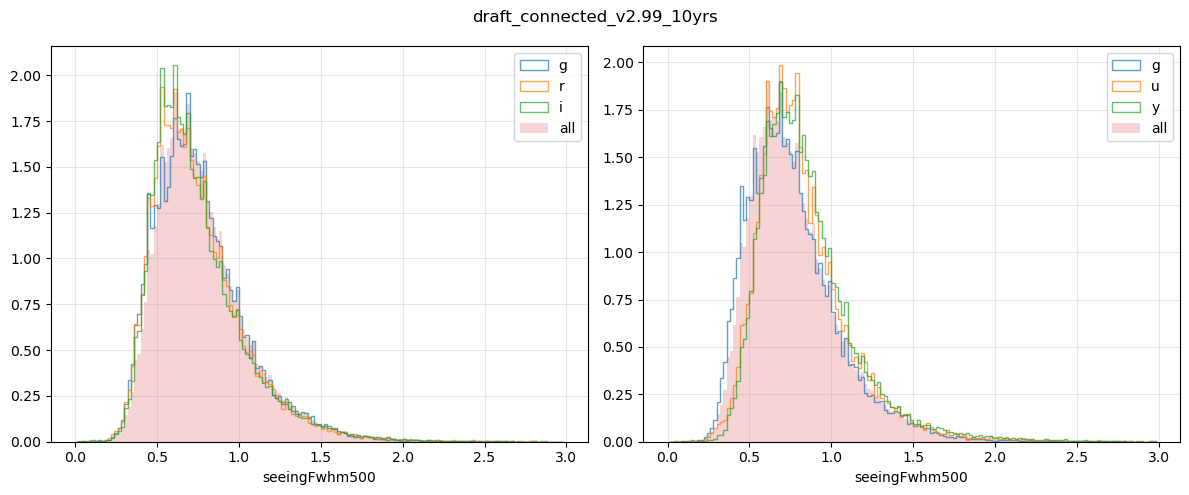

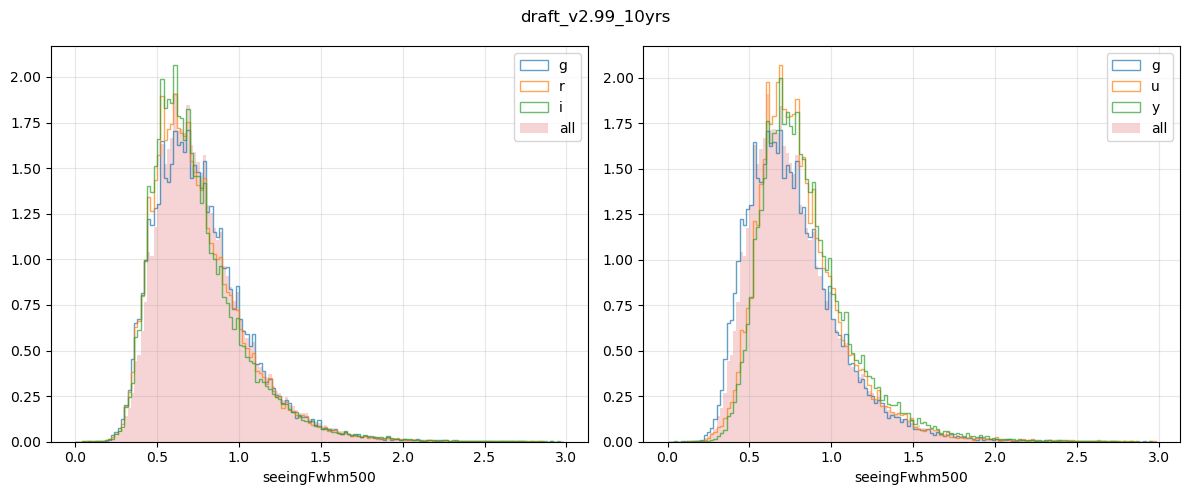

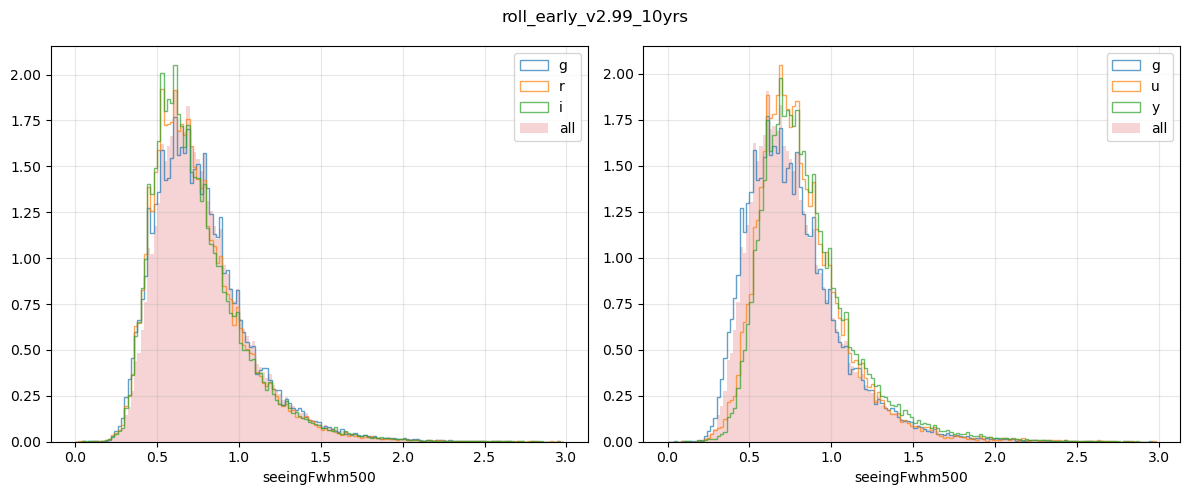

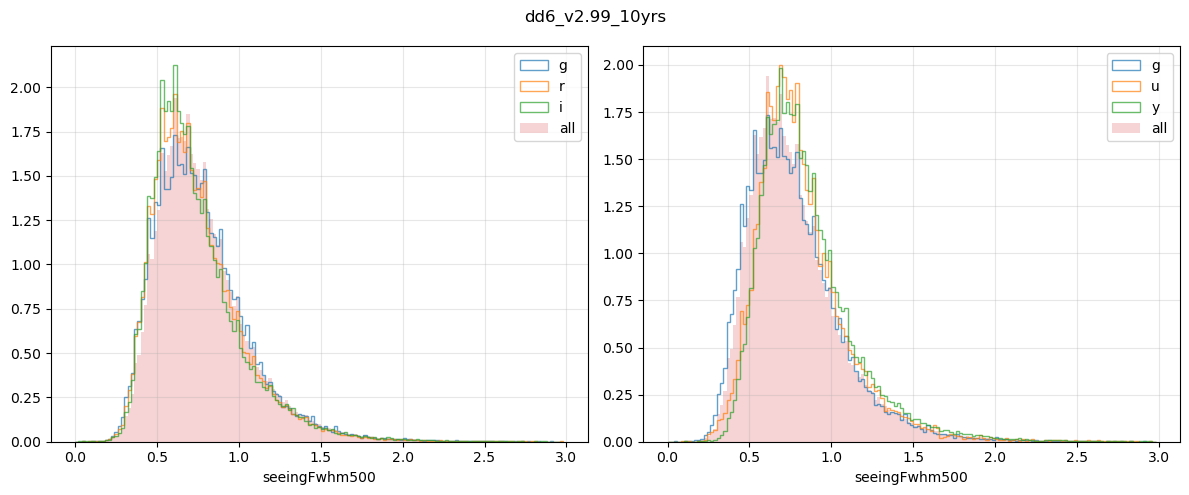

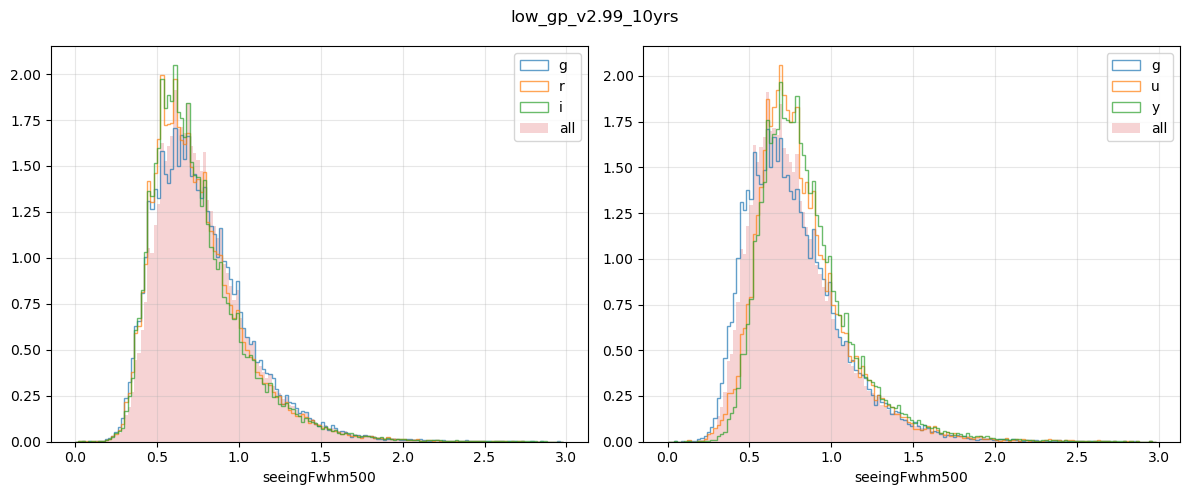

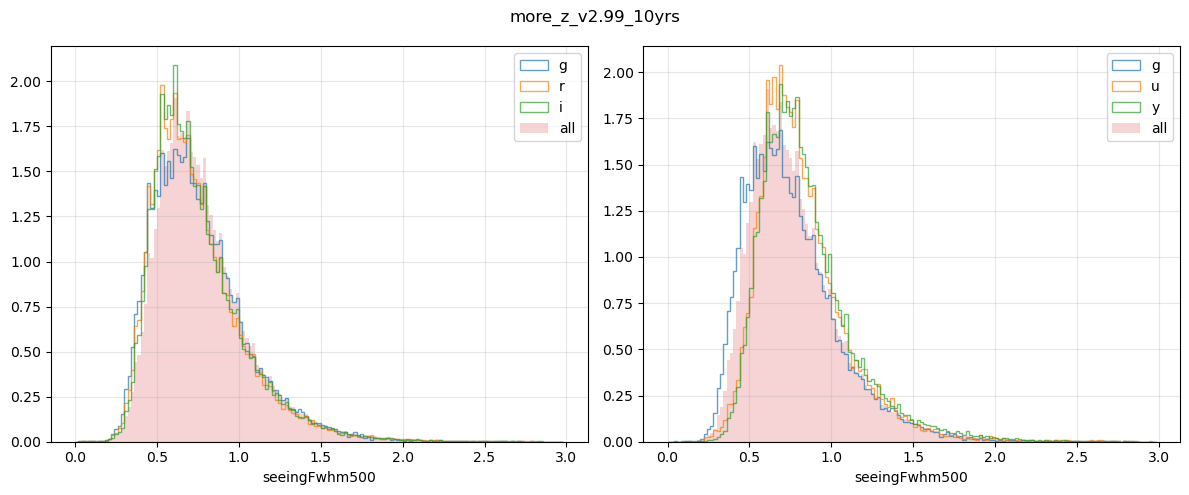

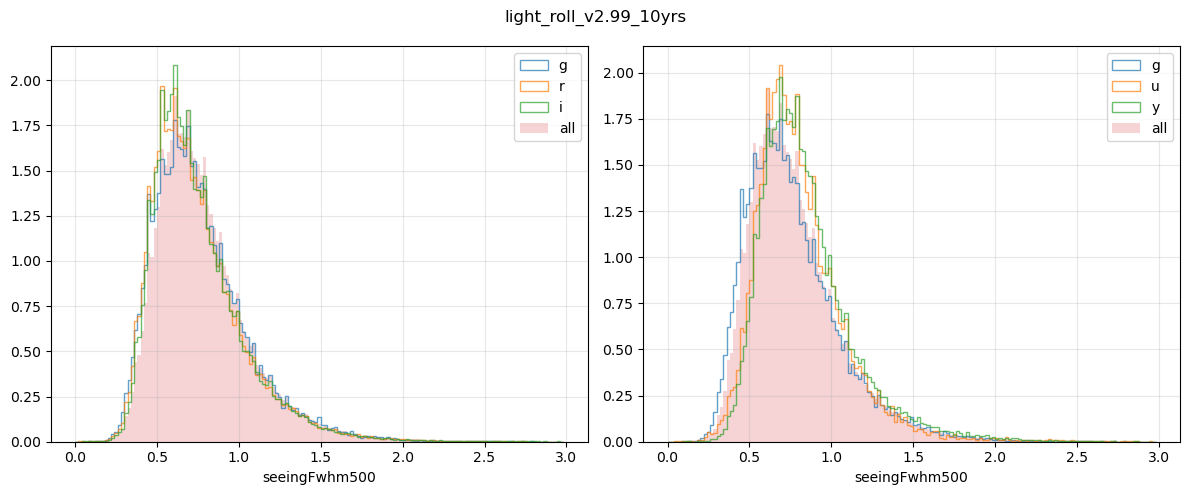

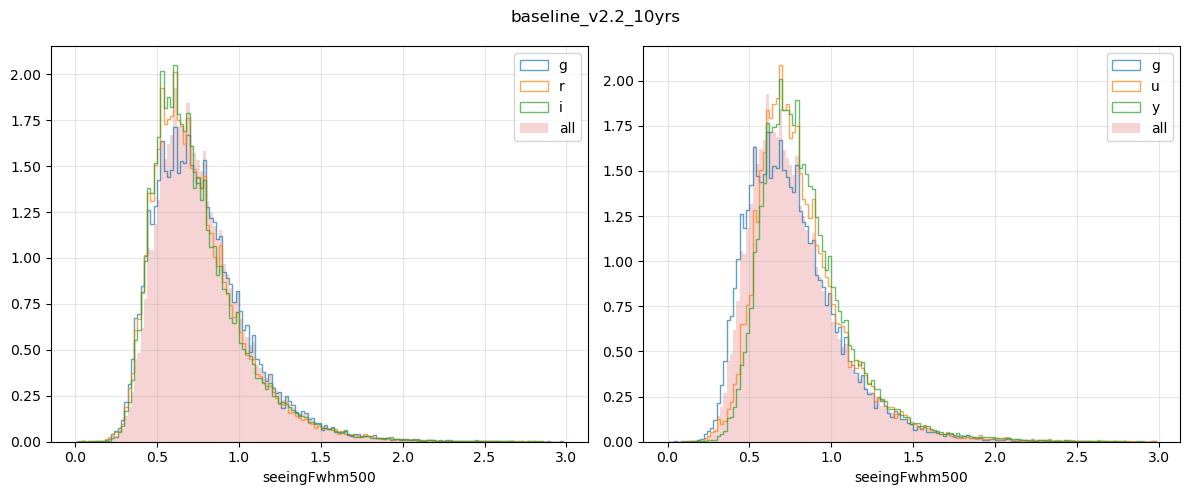

In [5]:
# Is the raw seeing distributed differently per filter? 
# Looks like yes, but only u/y (difference in g band is small)

bins = np.arange(0, 3, 0.02)
for r in d:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for f in 'gri':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhm500'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhm500'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xlabel('seeingFwhm500')
    plt.subplot(1, 2, 2)
    for f in 'guy':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhm500'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhm500'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xlabel('seeingFwhm500')
    plt.suptitle(r)
    plt.tight_layout()

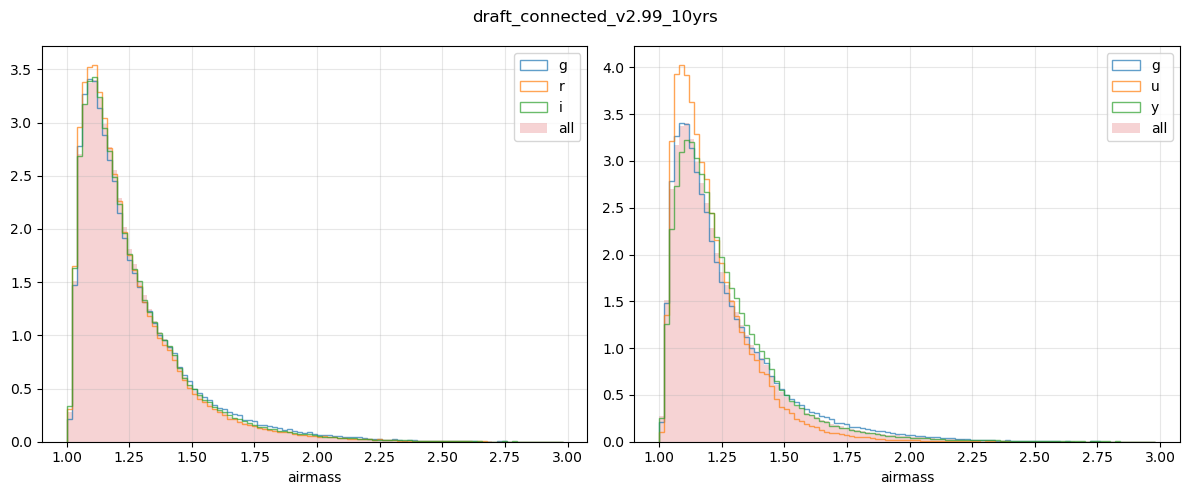

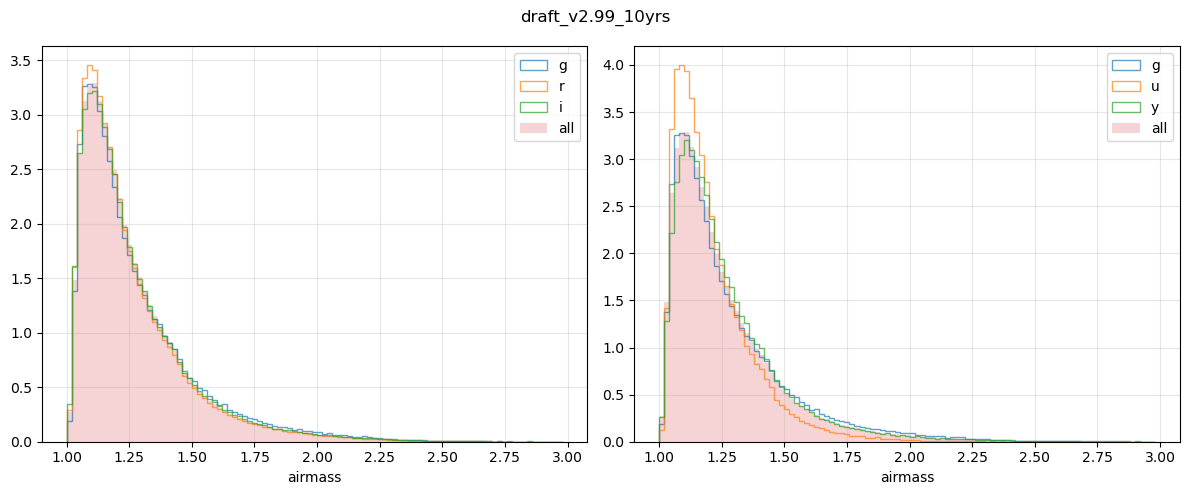

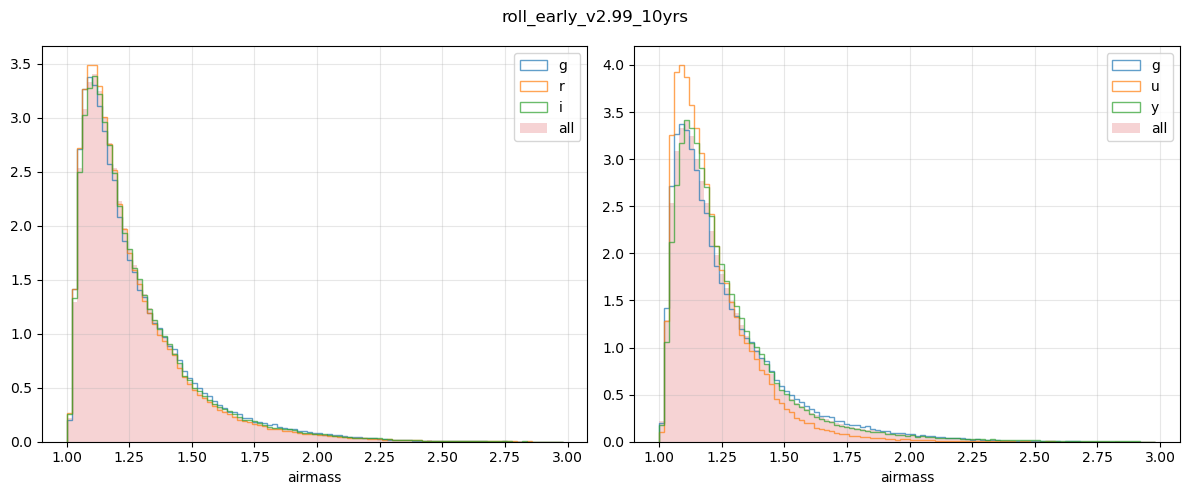

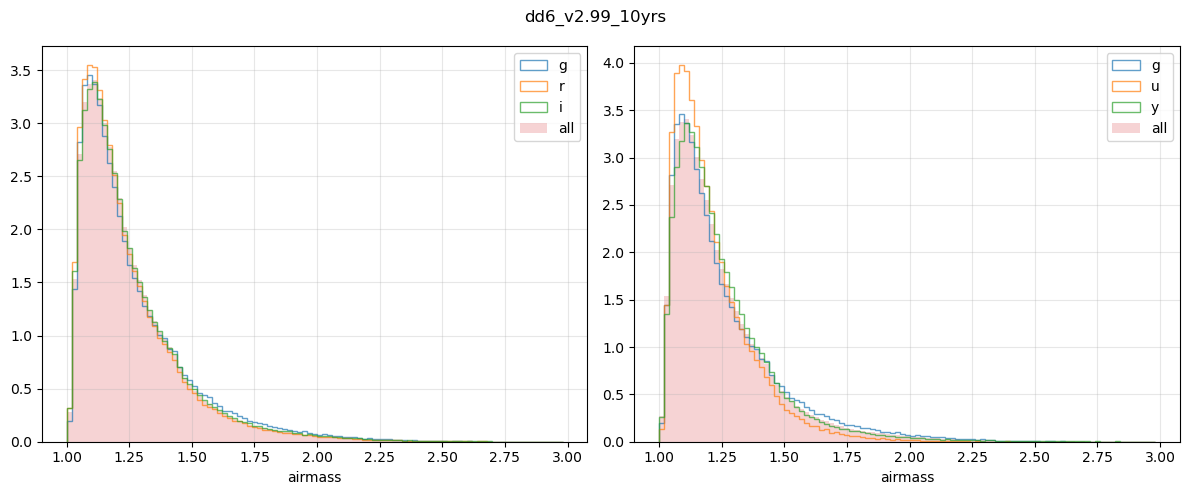

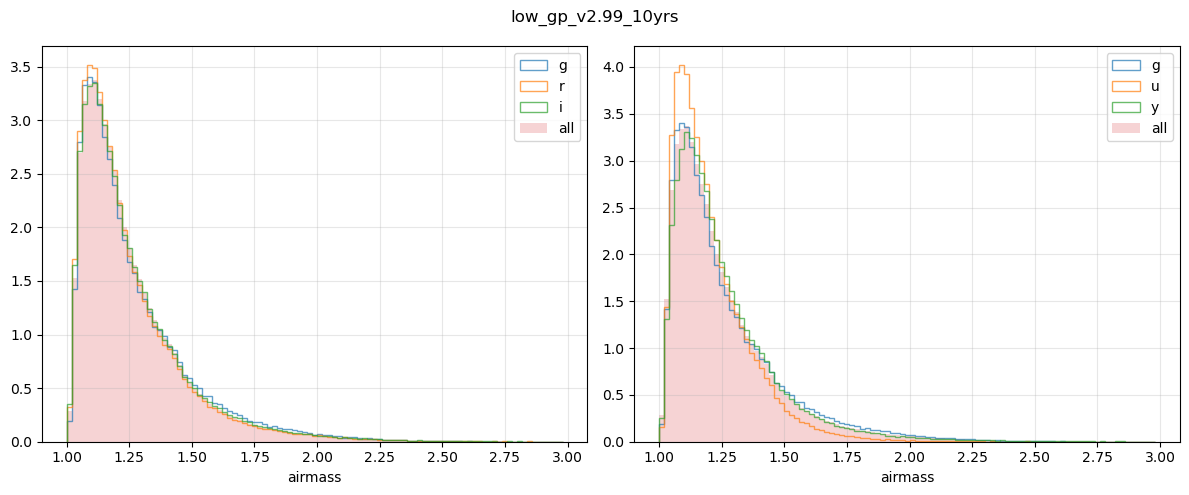

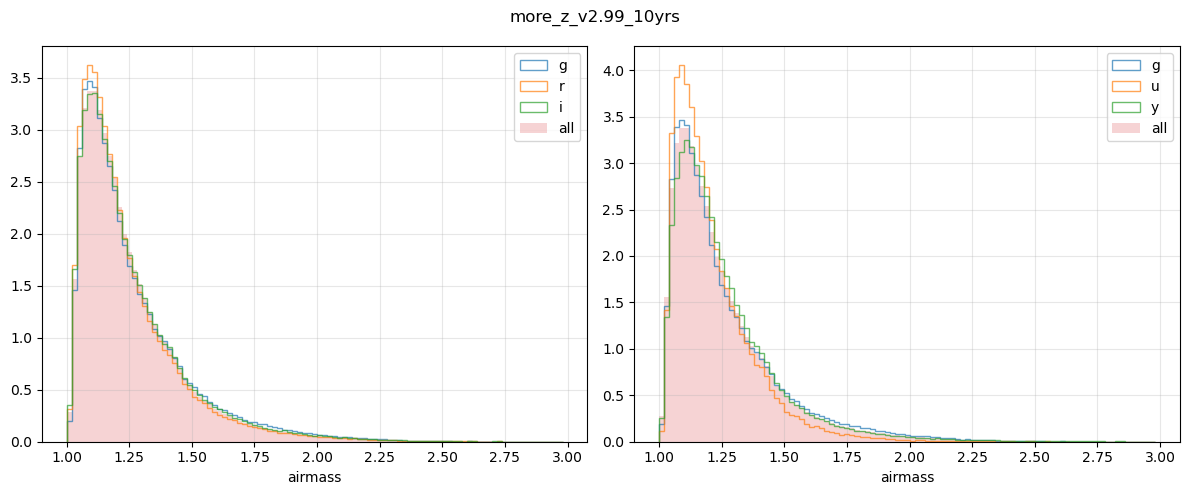

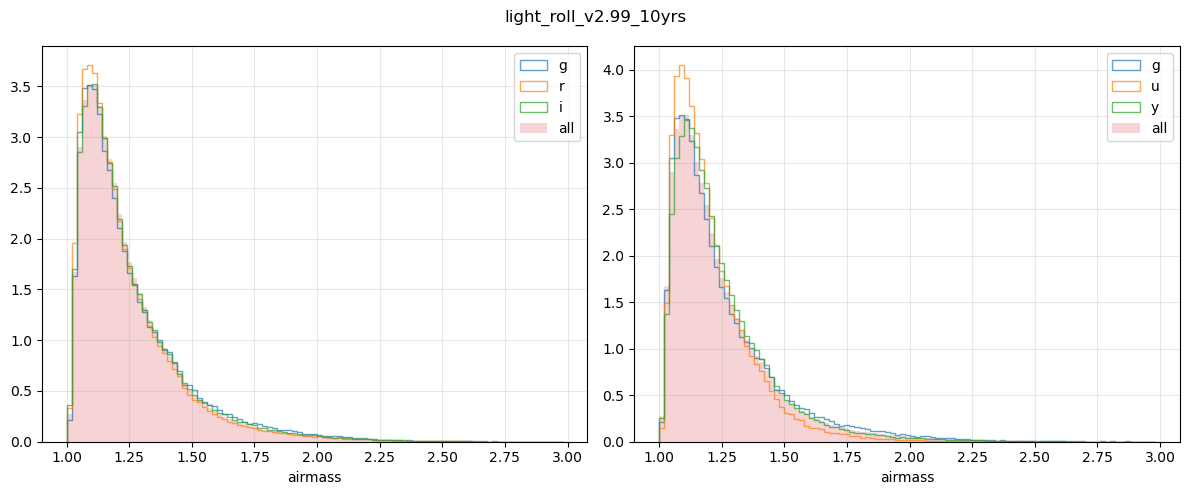

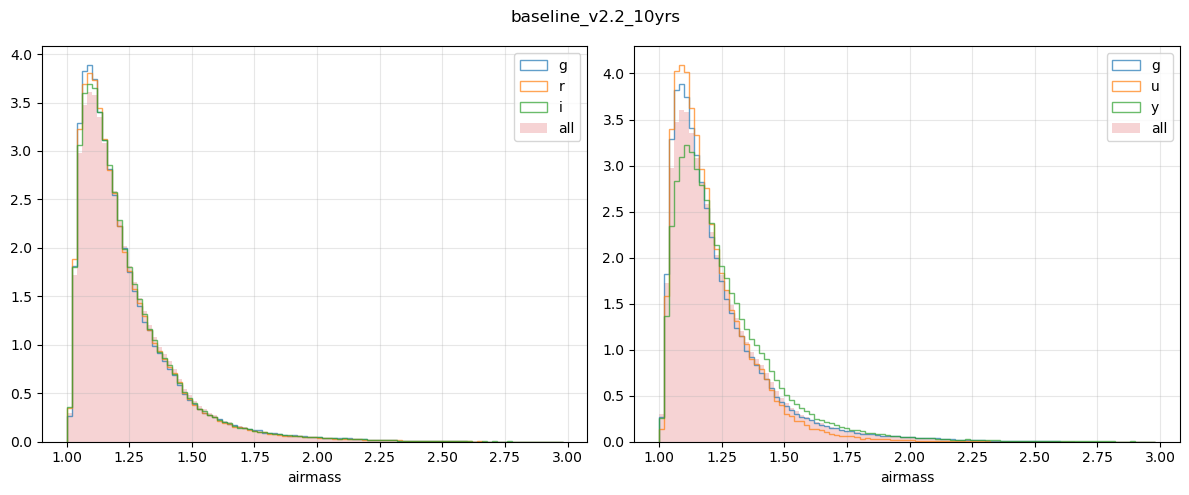

In [6]:
# What about airmass distribution? 
bins = np.arange(1, 3, 0.02)
for r in d:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for f in 'gri':
        t = d[r].query('filter == @f')
        plt.hist(t['airmass'], bins=bins, alpha=0.7,
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['airmass'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('airmass')
    plt.legend()
    plt.subplot(1, 2, 2)
    for f in 'guy':
        t = d[r].query('filter == @f')
        plt.hist(t['airmass'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['airmass'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('airmass')
    plt.legend()
    plt.suptitle(r)
    plt.tight_layout()

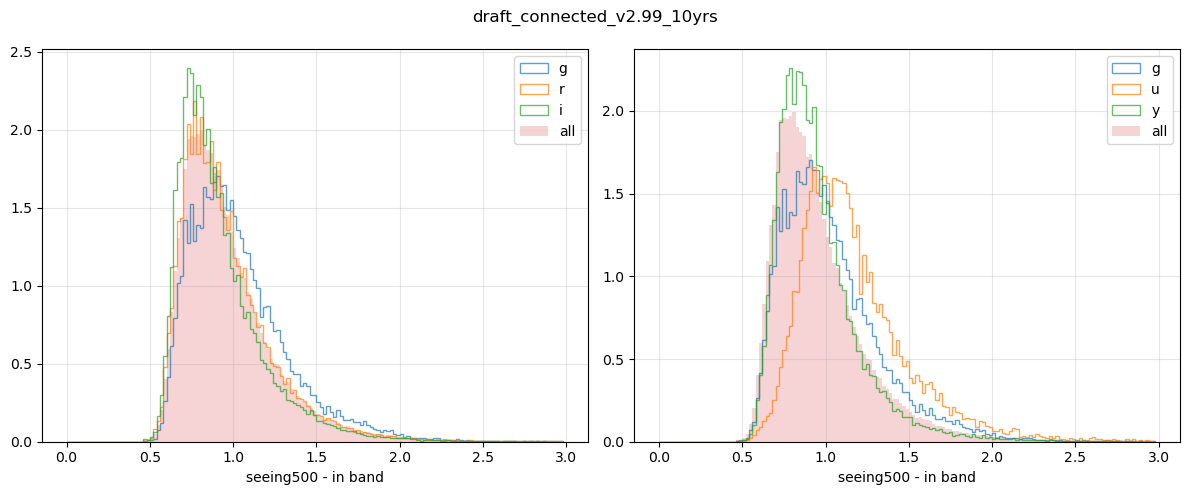

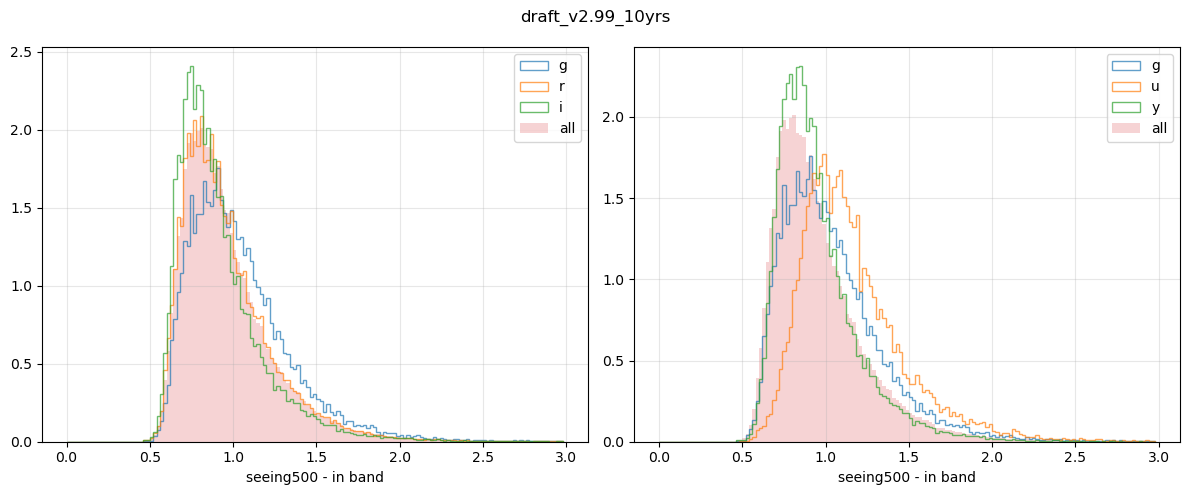

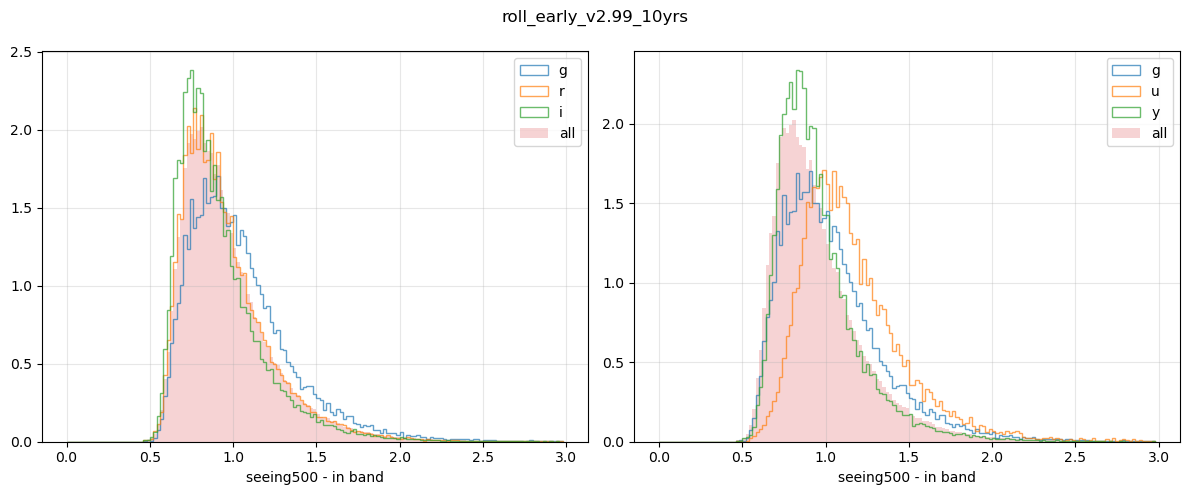

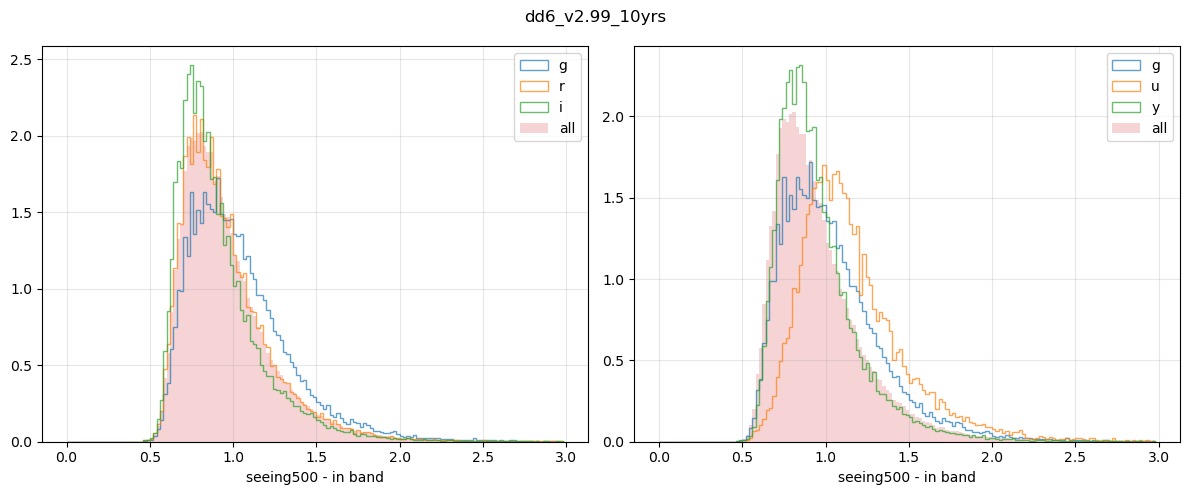

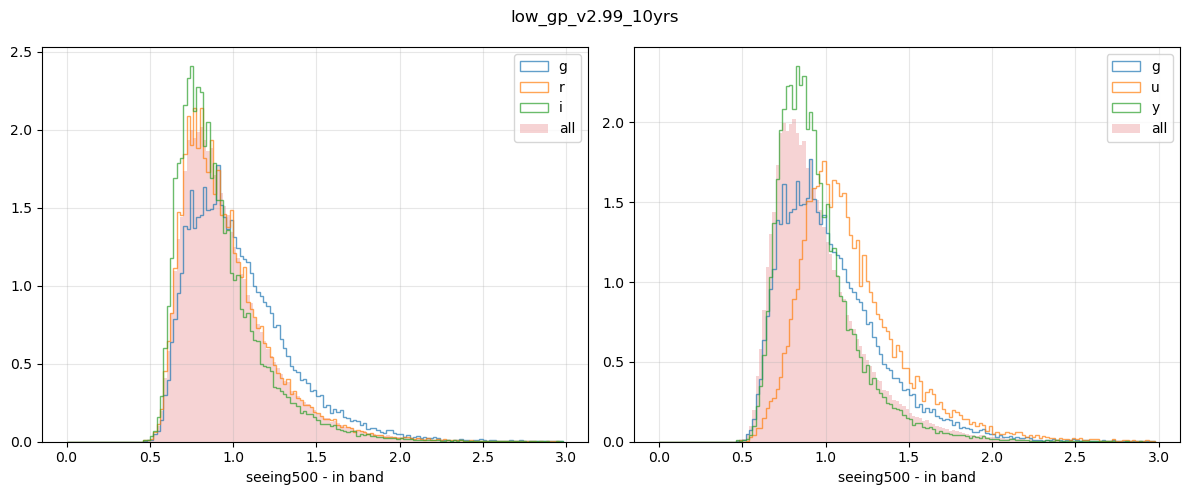

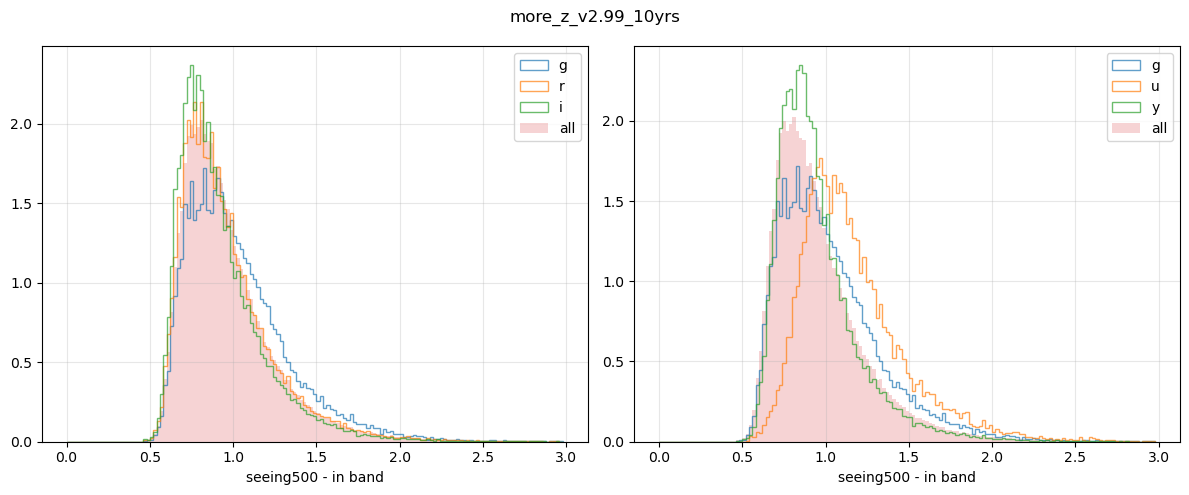

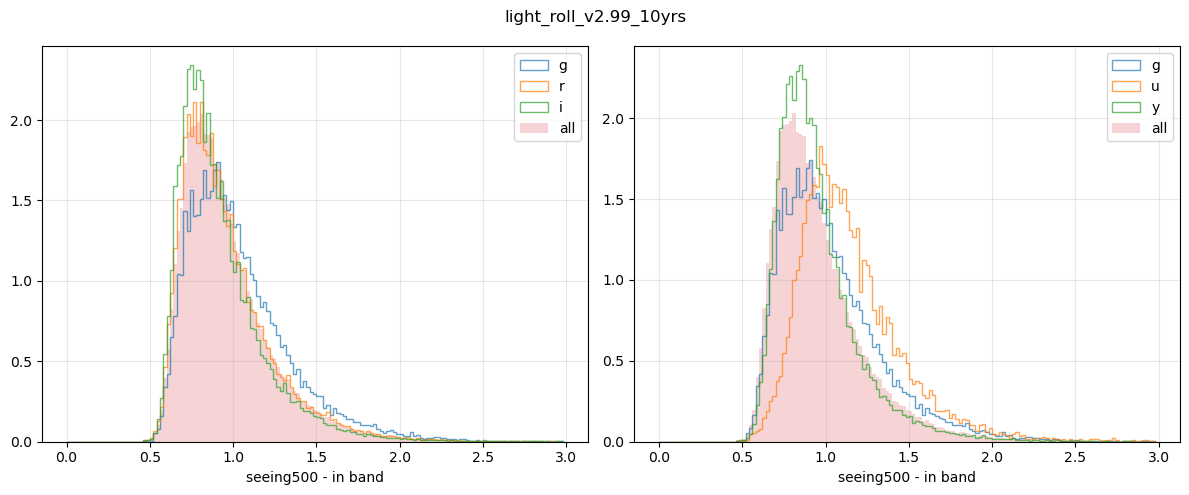

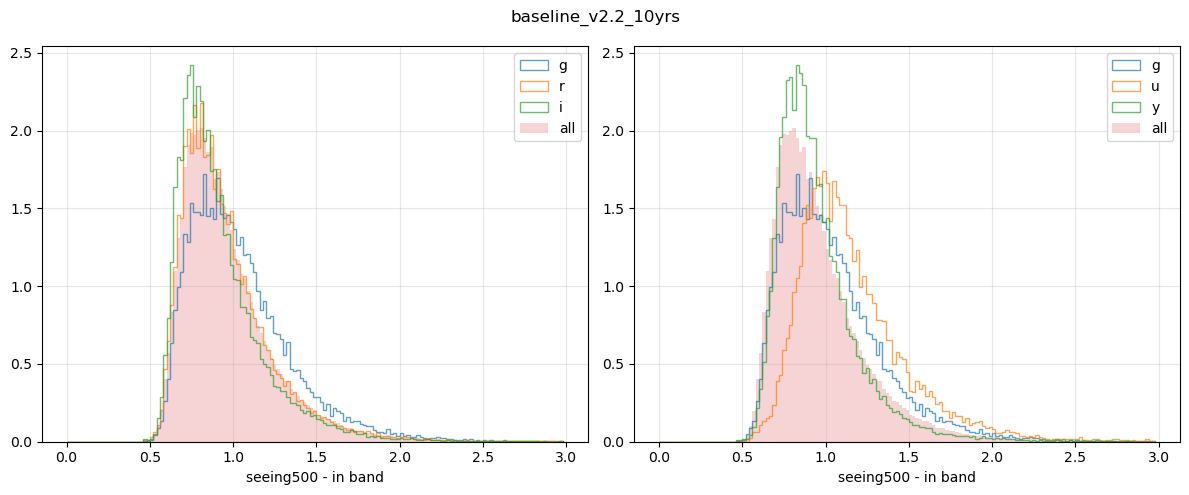

In [7]:
# If we take the raw seeing per bandpass and account for the wavelength dependency (only) do we see 
# what does the delivered seeing look like? 
# g band does seem to have more of a tail than ri but u band has a bigger effect

seeing = SeeingModel()
filter_list=["u", "g", "r", "i", "z", "y"]

bins = np.arange(0, 3, 0.02)

for r in d:
    band = np.zeros(len(d[r]))
    for f in 'ugrizy':
        match = np.where(d[r]['filter'] == f)
        i = filter_list.index(f)
        band[match] = seeing(d[r].iloc[match]['seeingFwhm500'].values, np.ones(len(match[0])))['fwhmEff'][i]
    d[r]['seeingBand'] = band
for r in d:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for f in 'gri':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingBand'], bins=bins, alpha=0.7,
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingBand'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('seeing500 - in band')
    plt.legend()
    plt.subplot(1, 2, 2)
    for f in 'guy':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingBand'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingBand'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('seeing500 - in band')
    plt.legend()
    plt.suptitle(r)
    plt.tight_layout()

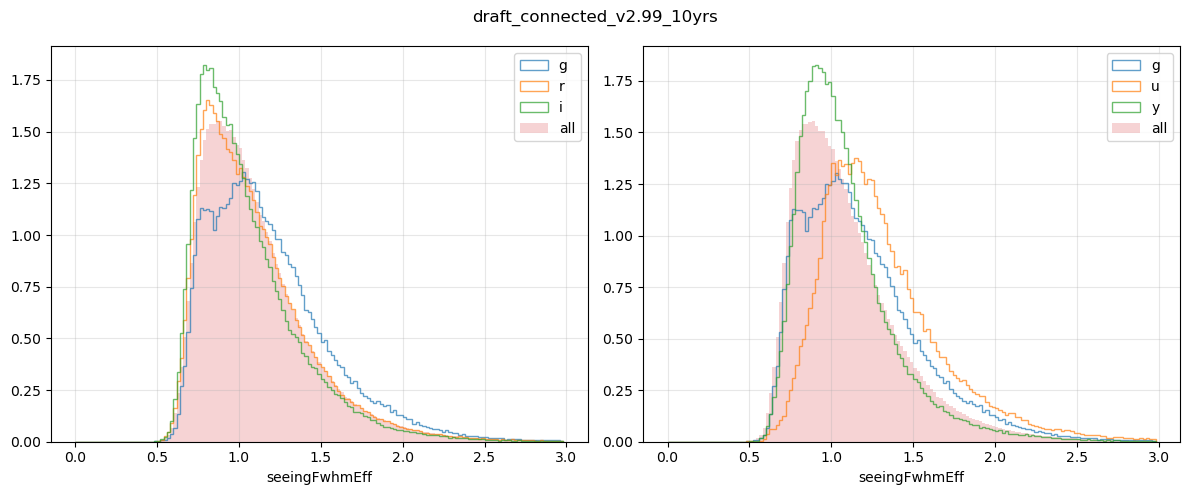

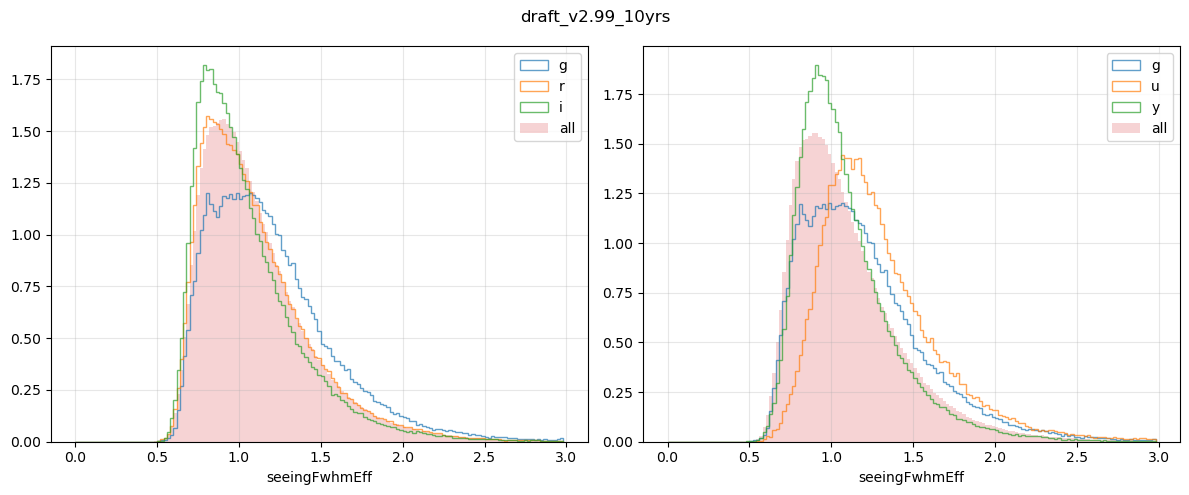

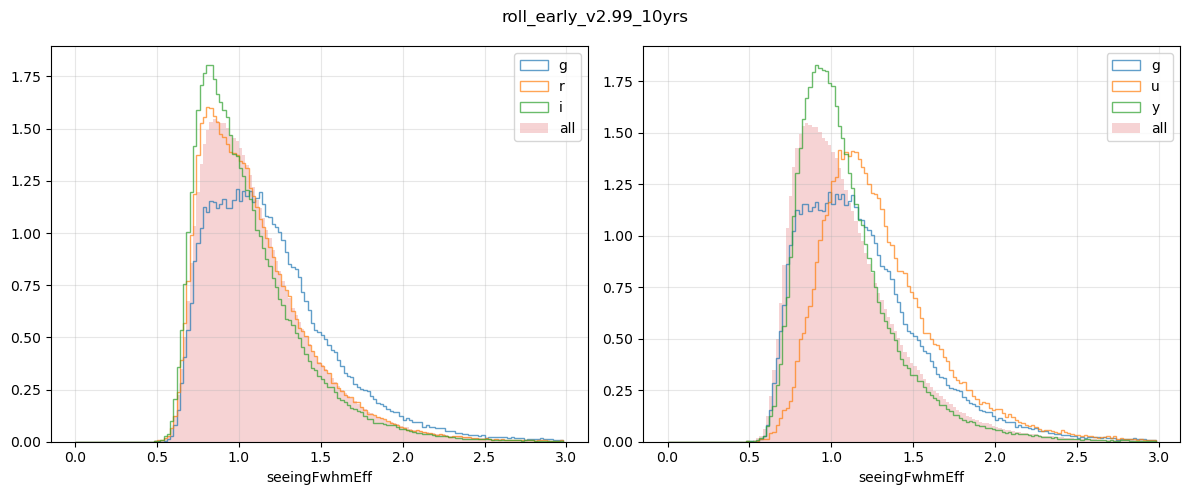

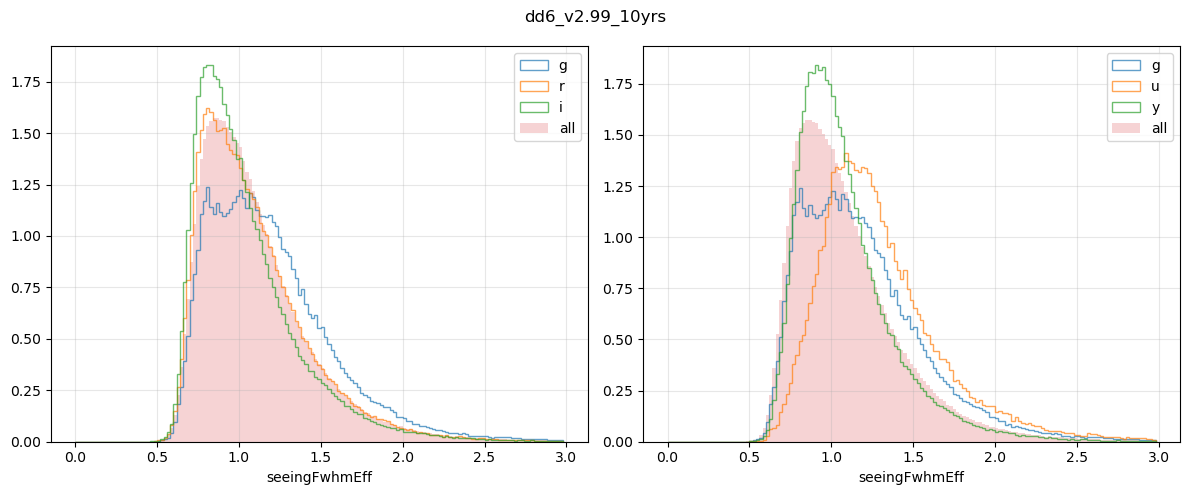

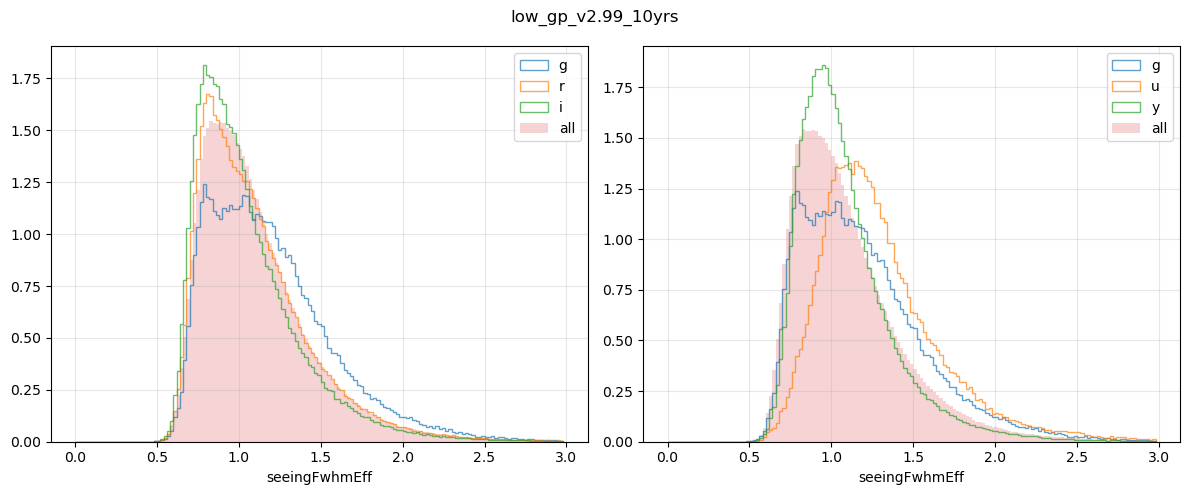

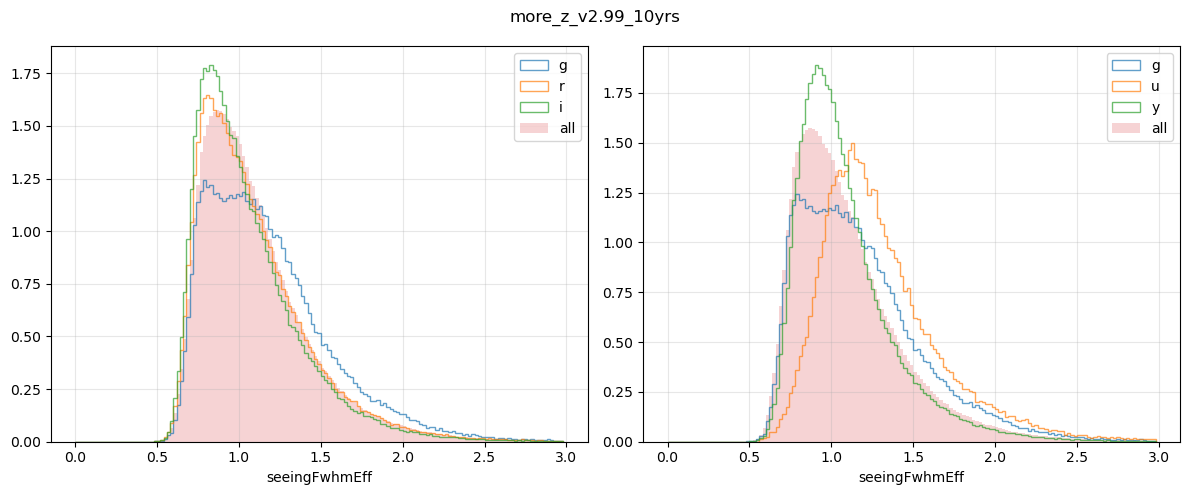

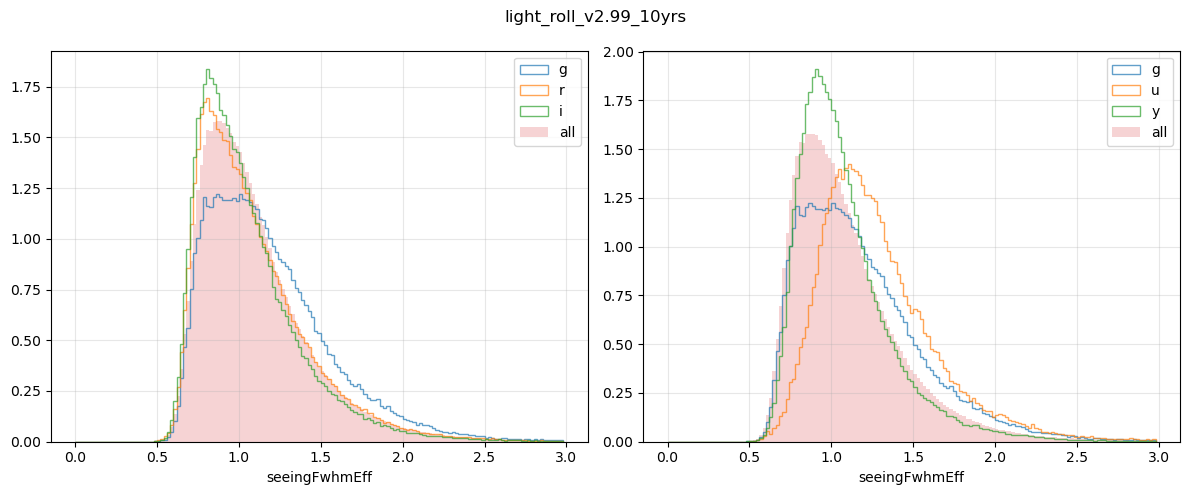

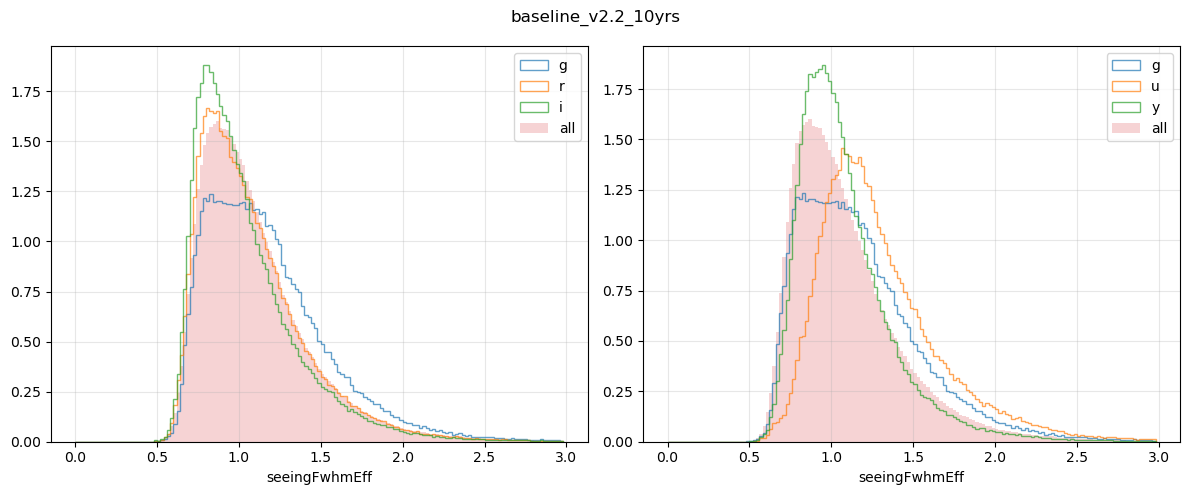

In [8]:
# How does that translate to delivered seeing (wavelength + airmass effects)?
# Looks like u band is definitely worse, g band showing some effects.  
# But, since the airmass distribution is basically the same for each bandpass, I think this is wavelength only.

bins = np.arange(0, 3, 0.02)
for r in d:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for f in 'gri':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhmEff'], bins=bins, alpha=0.7,
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhmEff'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('seeingFwhmEff')
    plt.legend()
    plt.subplot(1, 2, 2)
    for f in 'guy':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhmEff'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhmEff'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('seeingFwhmEff')
    plt.legend()
    plt.suptitle(r)
    plt.tight_layout()

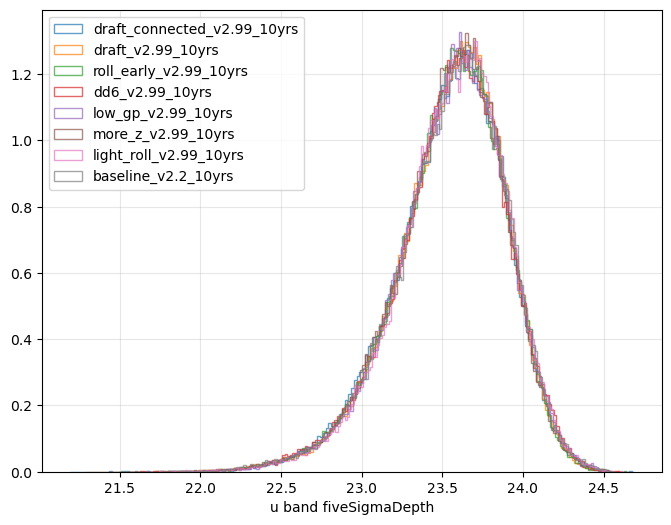

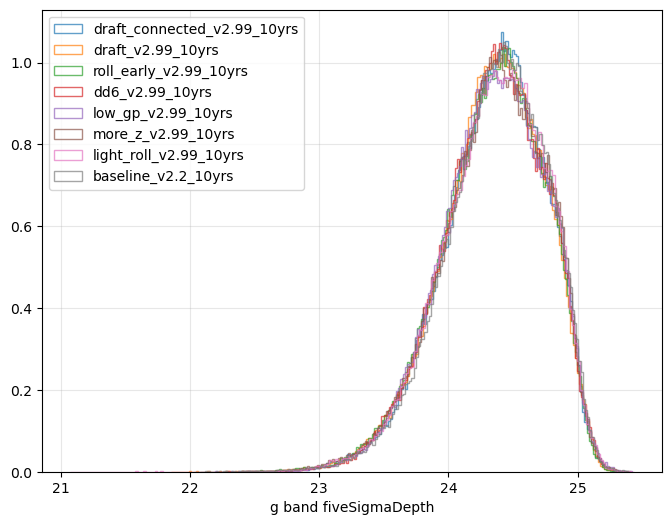

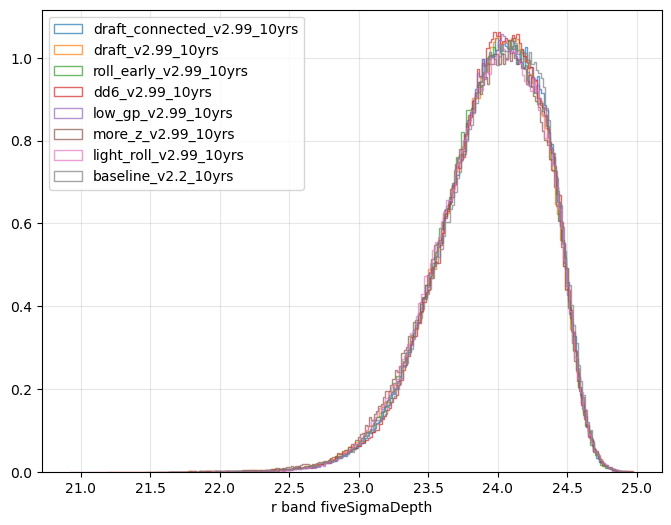

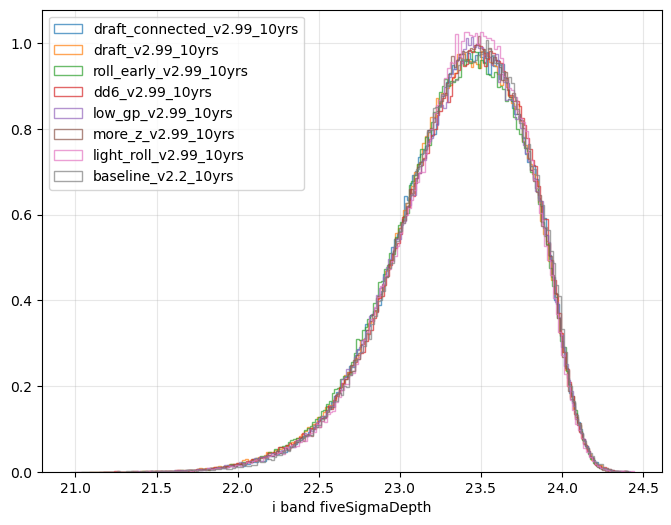

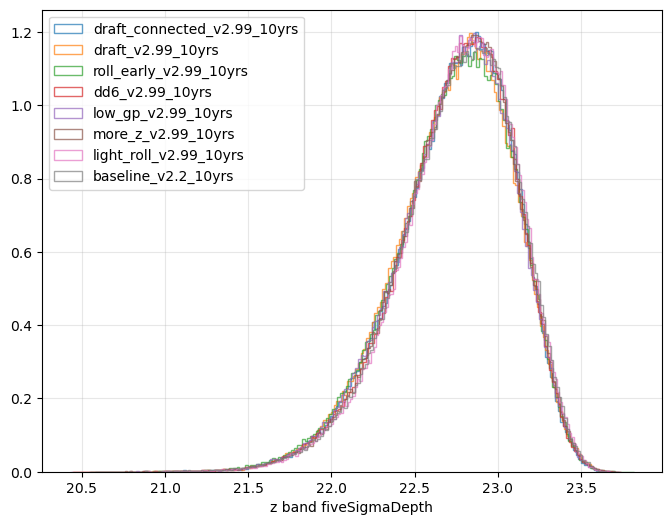

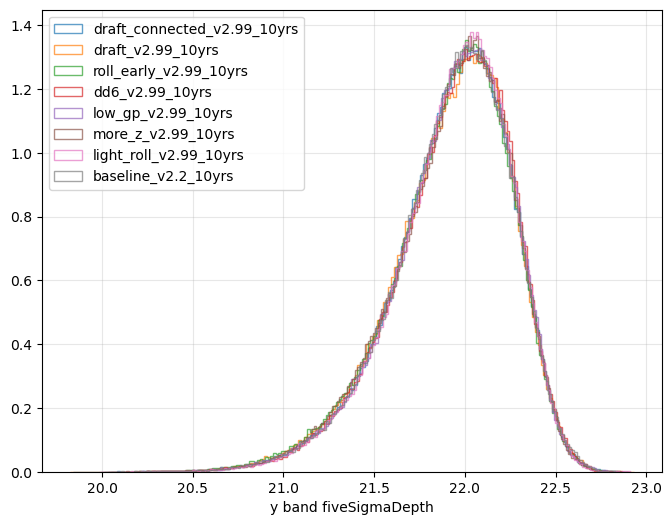

In [9]:
# So - what about the depth? Are different runs experiencing different depths for reasons? 
# Actually looks really consistent across runs. 
# Some slight flattening in the peak which may move the median, sometimes. 

bins = 200
for f in 'ugrizy':
    plt.figure(figsize=(8, 6))
    for r in d:
        t = d[r].query('filter == @f')
        plt.hist(t['fiveSigmaDepth'], bins=bins, alpha=0.7,
                 histtype='step', label=r, density=True)
    plt.grid(alpha=0.3)
    plt.xlabel(f'{f} band fiveSigmaDepth')
    plt.legend(loc='upper left')

In [12]:
# Compare against v1 - 
opsdb['baseline_nexp2_v1.7.1_10yrs'] = '/Users/lynnej/opsim/fbs_1.7/baseline_nexp2_v1.7.1_10yrs.db'

for r in ['baseline_nexp2_v1.7.1_10yrs']:
    conn = sqlite3.connect(opsdb[r])
    query = 'select observationStartMJD, night, filter, airmass, seeingFwhm500, seeingFwhmEff, '
    query += 'skyBrightness, fiveSigmaDepth, moonPhase from SummaryAllProps where note not like "%DD%" '
    query += ' and note not like "%twi%"'
    d[r] = pd.read_sql(query, conn)
    conn.close()

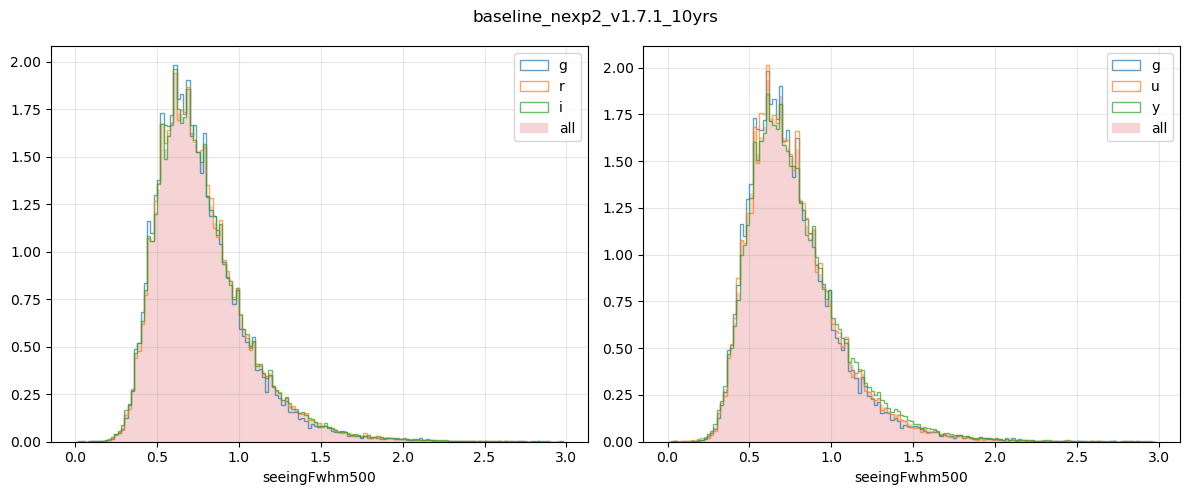

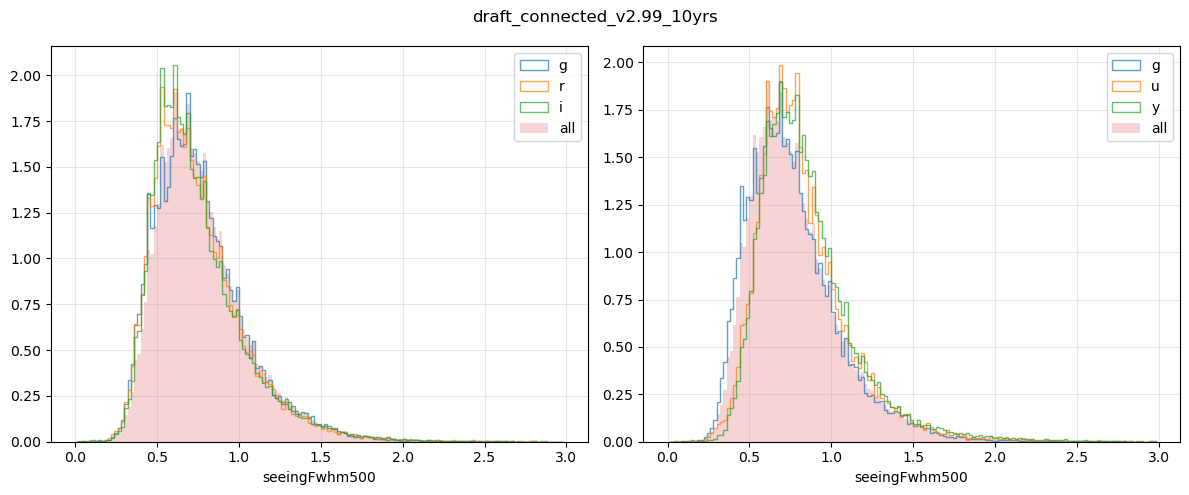

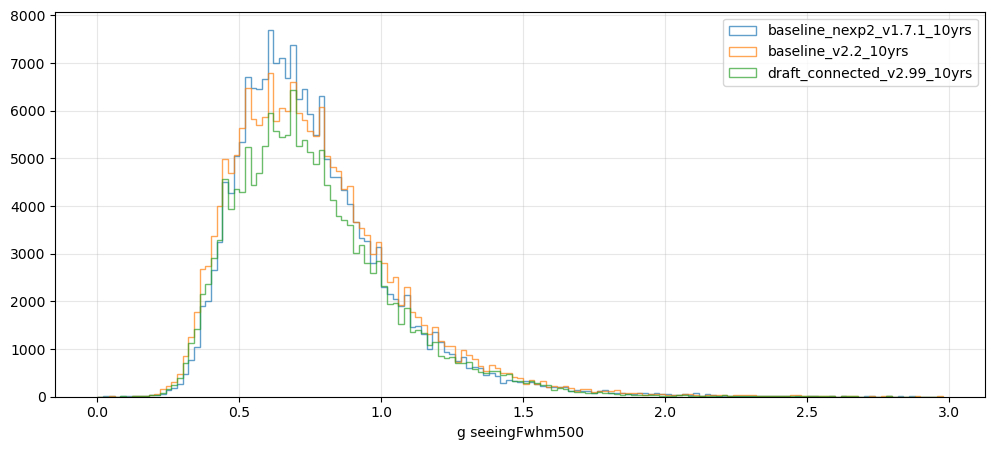

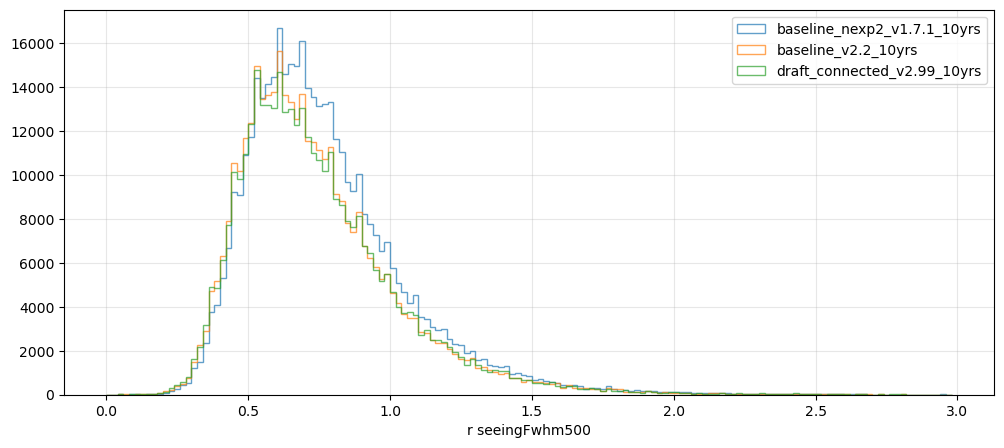

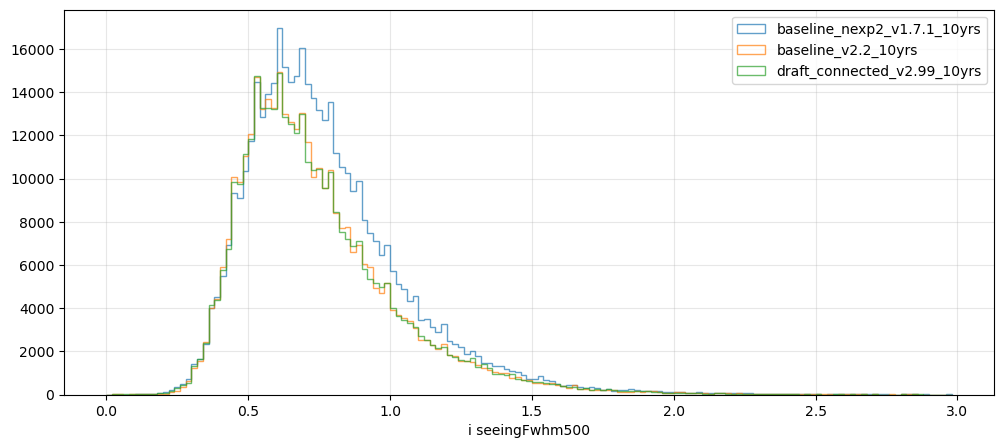

In [34]:
bins = np.arange(0, 3, 0.02)
for r in ['baseline_nexp2_v1.7.1_10yrs', 'draft_connected_v2.99_10yrs']:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for f in 'gri':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhm500'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhm500'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xlabel('seeingFwhm500')
    plt.subplot(1, 2, 2)
    for f in 'guy':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhm500'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhm500'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xlabel('seeingFwhm500')
    plt.suptitle(r)
    plt.tight_layout()

for f in 'gri':
    plt.figure(figsize=(12, 5))
    for r in ['baseline_nexp2_v1.7.1_10yrs', 'baseline_v2.2_10yrs', 'draft_connected_v2.99_10yrs']:
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhm500'], bins=bins, alpha=0.7,
                 histtype='step', label=r, density=False)
        plt.grid(alpha=0.3)
        plt.xlabel(f'{f} seeingFwhm500')
        plt.legend()

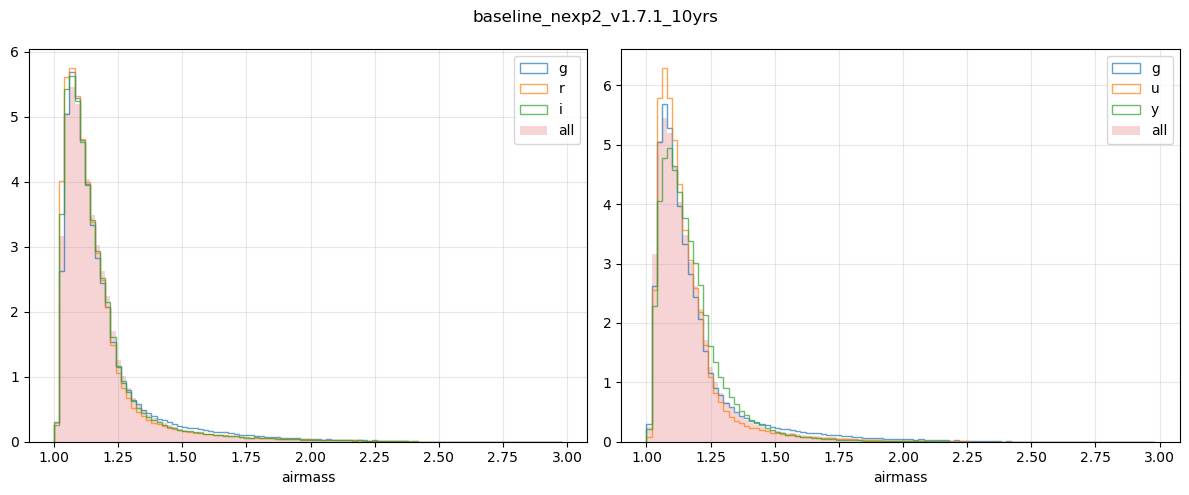

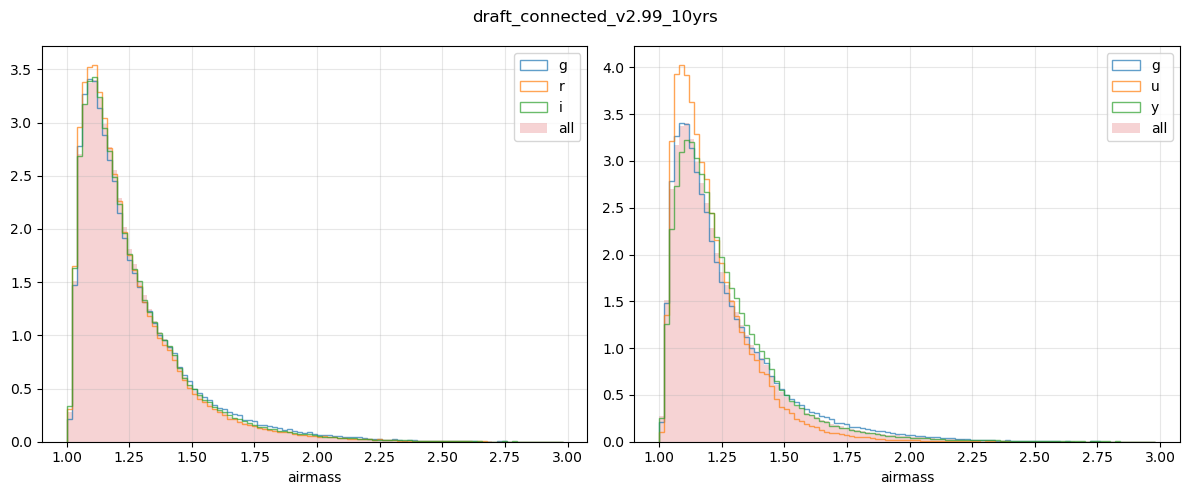

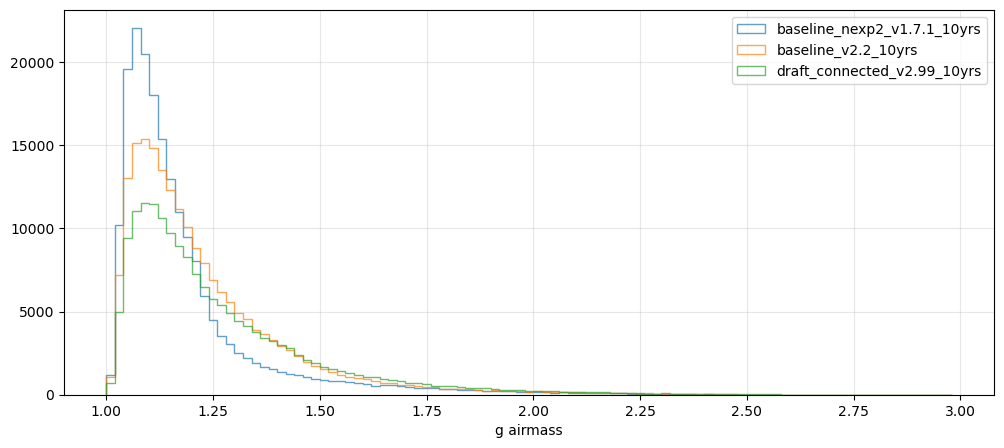

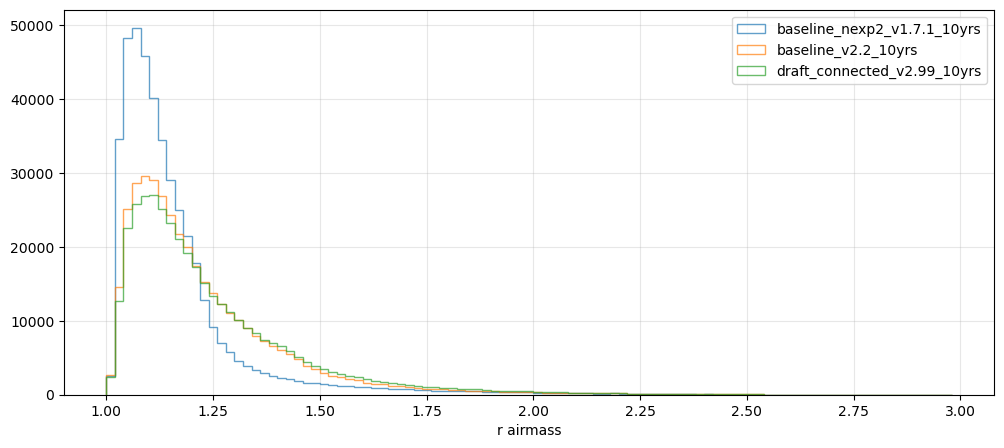

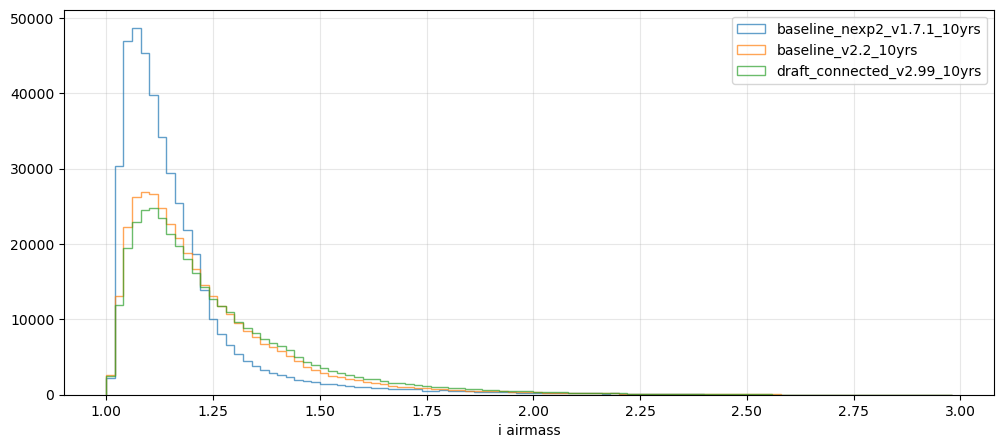

In [33]:
bins = np.arange(1, 3, 0.02)
for r in ['baseline_nexp2_v1.7.1_10yrs', 'draft_connected_v2.99_10yrs']:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for f in 'gri':
        t = d[r].query('filter == @f')
        plt.hist(t['airmass'], bins=bins, alpha=0.7,
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['airmass'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('airmass')
    plt.legend()
    plt.subplot(1, 2, 2)
    for f in 'guy':
        t = d[r].query('filter == @f')
        plt.hist(t['airmass'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['airmass'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('airmass')
    plt.legend()
    plt.suptitle(r)
    plt.tight_layout()
    
for f in 'gri':
    plt.figure(figsize=(12, 5))
    for r in ['baseline_nexp2_v1.7.1_10yrs', 'baseline_v2.2_10yrs', 'draft_connected_v2.99_10yrs']:
        t = d[r].query('filter == @f')
        plt.hist(t['airmass'], bins=bins, alpha=0.7,
                 histtype='step', label=r, density=False)
        plt.grid(alpha=0.3)
        plt.xlabel(f'{f} airmass')
        plt.legend()

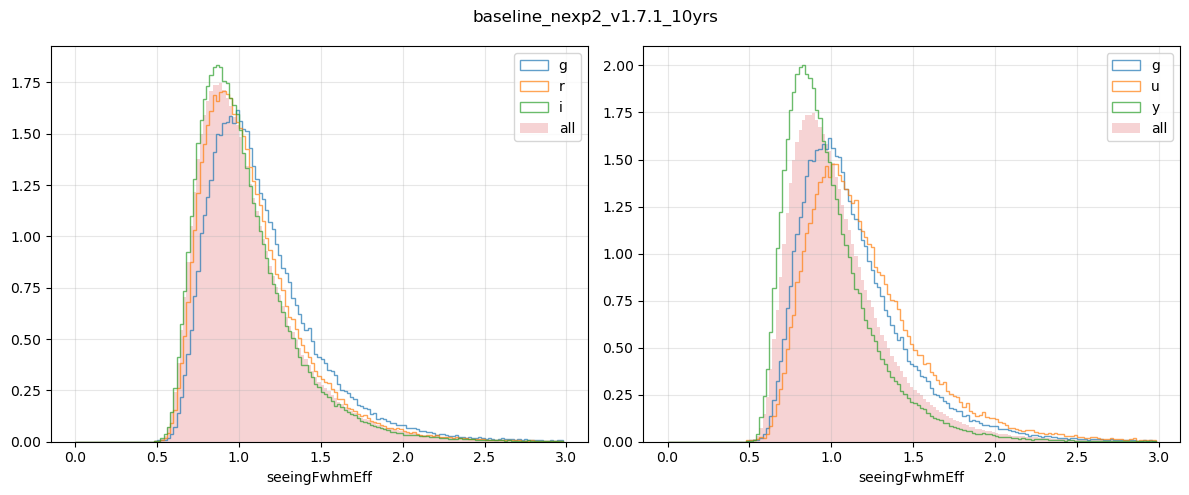

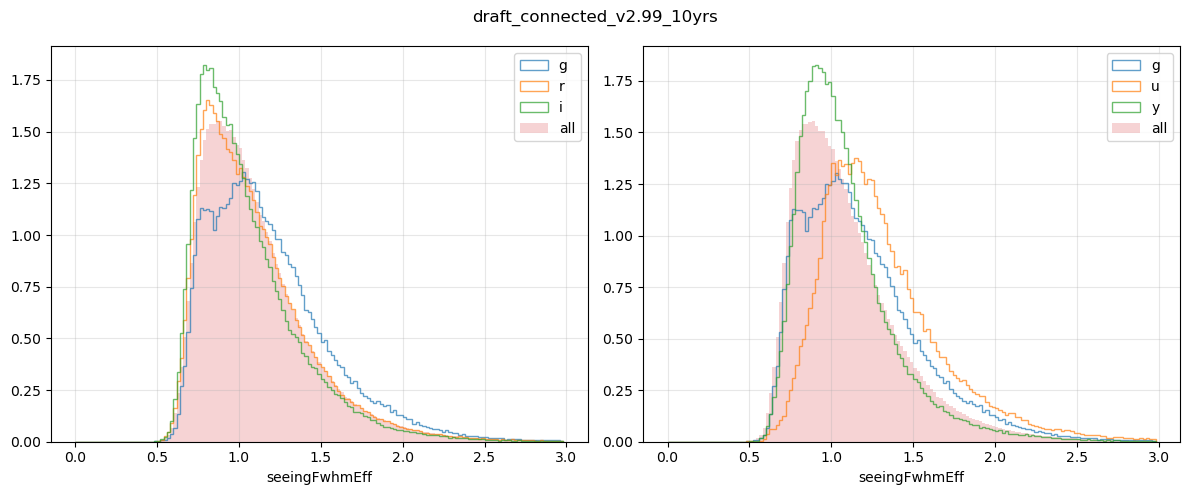

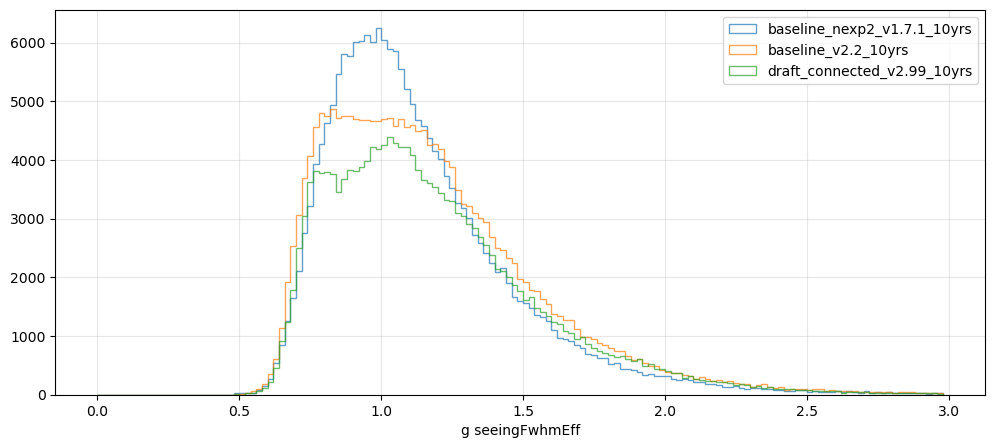

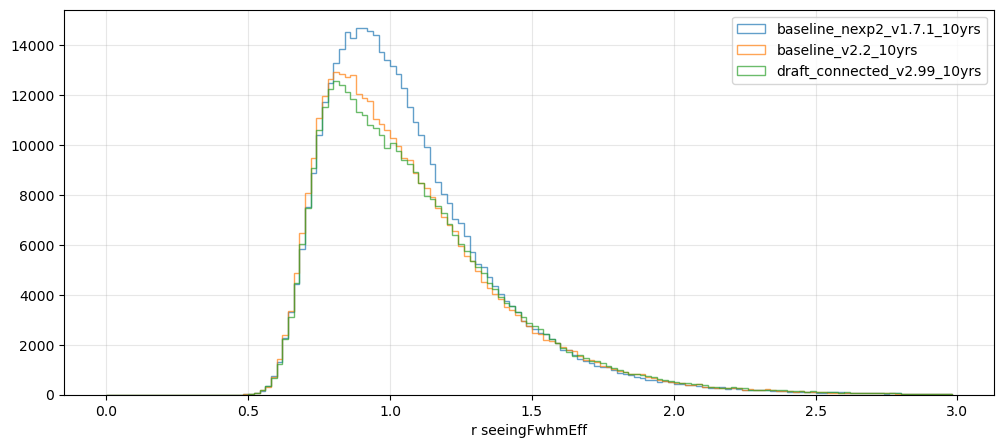

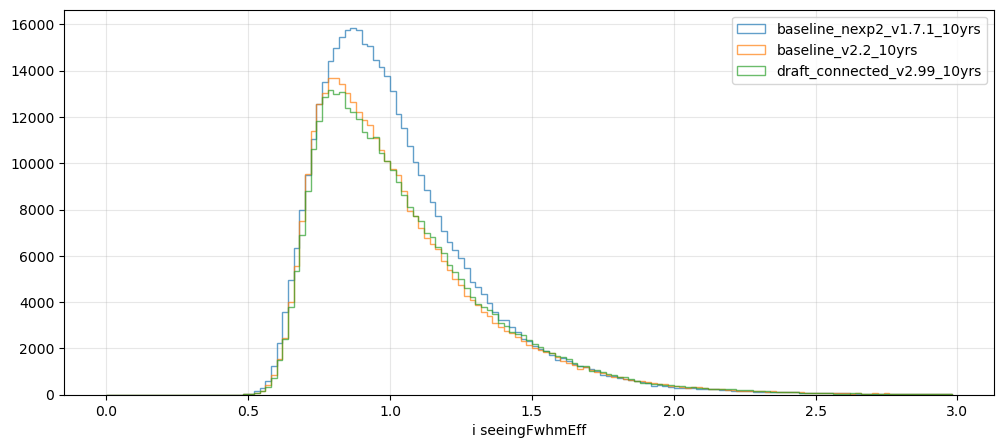

In [35]:
bins = np.arange(0, 3, 0.02)
for r in ['baseline_nexp2_v1.7.1_10yrs', 'draft_connected_v2.99_10yrs']:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for f in 'gri':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhmEff'], bins=bins, alpha=0.7,
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhmEff'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('seeingFwhmEff')
    plt.legend()
    plt.subplot(1, 2, 2)
    for f in 'guy':
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhmEff'], bins=bins, alpha=0.7, 
                 histtype='step', label=f, density=True)
    plt.hist(d[r]['seeingFwhmEff'], bins=bins, alpha=0.2, label='all', density=True)
    plt.grid(alpha=0.3)
    plt.xlabel('seeingFwhmEff')
    plt.legend()
    plt.suptitle(r)
    plt.tight_layout()
    
for f in 'gri':
    plt.figure(figsize=(12, 5))
    for r in ['baseline_nexp2_v1.7.1_10yrs',  'baseline_v2.2_10yrs', 'draft_connected_v2.99_10yrs']:
        t = d[r].query('filter == @f')
        plt.hist(t['seeingFwhmEff'], bins=bins, alpha=0.7,
                 histtype='step', label=r, density=False)
        plt.grid(alpha=0.3)
        plt.xlabel(f'{f} seeingFwhmEff')
        plt.legend()

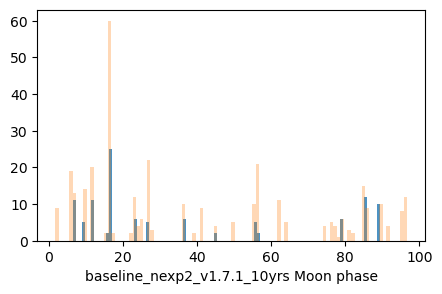

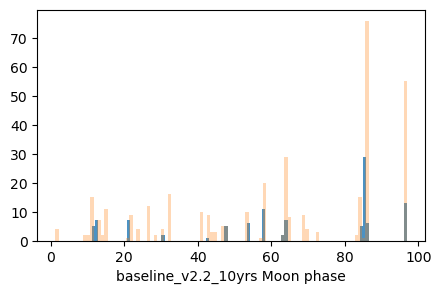

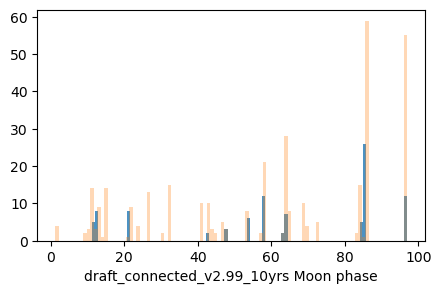

In [90]:
for r in ['baseline_nexp2_v1.7.1_10yrs', 'baseline_v2.2_10yrs', 'draft_connected_v2.99_10yrs']:
    plt.figure(figsize=(5,3))
    val = 0.07
    match = np.where(d[r]['seeingFwhm500'] < val)[0]
    plt.hist(d[r].iloc[match]['moonPhase'], bins=100, alpha=0.8, density=False)
    match = np.where(d[r]['seeingFwhm500'] < val*2)[0]
    plt.hist(d[r].iloc[match]['moonPhase'], bins=100, alpha=0.3, density=False)
    plt.xlabel(f"{r} Moon phase")